In [1]:
%load_ext autoreload
%autoreload 2

import os,sys,inspect
# current_dir = '/home/jiayuand/seqOED_variational/examples/location'
# parent_dir = '/home/jiayuand/seqOED_variational'

# current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
# parent_dir = os.path.dirname(os.path.dirname(current_dir))
parent_dir = '/scratch/xhuan_root/xhuan1/wgshen/vsOED/'
sys.path.insert(0, parent_dir) 

import numpy as np
# from scipy.stats import norm, beta, dirichlet
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from   torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"  
device = torch.device(dev) 
torch.set_default_device(device)
dtype = torch.float32
torch.set_default_dtype(dtype)

from vsOED import VSOED, PGvsOED, GMM_NET, NFs, POST_APPROX
from vsOED.utils import *
from vsOED.models import *

import dowel

In [2]:
n_stage      = 10       # Number of stages.
n_design     = 6        # Number of design variables.
n_obs        = 1        # Number of observations.
n_pois       = [4]        # Number of parameters.
n_nuisps     = None
n_goals      = None
model_weight = 0
poi_weight   = 1
goal_weight  = 0

random_state  = TRAIN_SEEDS[0]
set_random_seed(random_state)

model = CES()
prior = model

mu_bounds = {}
mu_bounds['poi'] = []
for n_poi in n_pois:
    mu_bounds['poi'].append([[-1, 2], [-1, 2], [-1, 2], [-17, 19]])
if n_goals is not None:
    mu_bounds['goal'] = []
    for n_goal in n_goals:
        mu_bounds['goal'].append([[0, 3]] * n_goal)
max_sigmas = {}
max_sigmas['poi'] = []
for n_poi in n_pois:
    max_sigmas['poi'].append([3.0] * n_poi)
if n_goals is not None:
    max_sigmas['goal'] = []
    for n_goal in n_goals:
        max_sigmas['goal'].append([1.0] * n_goal)
truncnorm_info = {}
truncnorm_info['poi'] = [[[0, 0., 1.], [1, 0., 1.], [2, 0., 1.]]]
if n_goals is not None:
    truncnorm_info['goal'] = []
    for n_goal in n_goals:
        info = []
        for i in range(n_goal):
            info.append([i, 0, 4])
            
n_incre = 10
share_interm_net = False

candidate_lrs = [[1e-3] * n_incre, [1e-5] * (n_incre - 1) + [1e-4]]
candidate_gammas = [[0.9999] * n_incre, [0.999999] * (n_incre - 1) + [0.99999]]
model_post_lrs = candidate_lrs[share_interm_net]
model_post_lr_scheduler_gammas = candidate_gammas[share_interm_net]
poi_post_lrs = candidate_lrs[share_interm_net]
poi_post_lr_scheduler_gammas = candidate_gammas[share_interm_net]
goal_post_lrs = candidate_lrs[share_interm_net]
goal_post_lr_scheduler_gammas = candidate_gammas[share_interm_net]

use_NFs = False
n_mixture = 8
activate = nn.ReLU

log_every = 100
folder = parent_dir + f'experiments/ces_{len(n_pois)}model_{n_stage}stage_{n_incre}incre_GMM/'
try:
    os.remove(folder + 'progress.csv')
except:
    pass
try:
    os.remove(folder + 'progress.txt')
except:
    pass
try:
    dowel.logger.remove_all()
except:
    pass
dowel.logger.add_output(dowel.StdOutput())
dowel.logger.add_output(dowel.CsvOutput(folder + 'progress.csv'))
dowel.logger.add_output(dowel.TextOutput(folder + 'progress.txt'))

try:
    for _ in range(100):
        dowel.logger.pop_prefix()
except:
    pass
dowel.logger.push_prefix('[CES] ')
dowel.logger.log('Stored at ' + folder)
dowel.logger.log('Random seed:  ' + str(random_state))
dowel.logger.log('Device: ' + str(device))
dowel.logger.log('dtype: ' + str(dtype))

post_approx_params = {
    'n_stage': n_stage, 
    'n_design': n_design, 
    'n_obs': n_obs, 
    'n_pois': n_pois,
    'n_nuisps': n_nuisps,
    'n_goals': n_goals,
    'model_weight': model_weight,
    'poi_weight': poi_weight,
    'goal_weight': goal_weight,
    'mu_bounds': mu_bounds,
    'max_sigmas': max_sigmas,
    'truncnorm_info': truncnorm_info,
    'n_mixture': n_mixture,
    'activate': activate,
    'prior': prior,
    'n_incre': n_incre,
    'share_interm_net': share_interm_net,
    'model_post_lrs': model_post_lrs,
    'model_post_lr_scheduler_gammas': model_post_lr_scheduler_gammas,
    'poi_post_lrs': poi_post_lrs,
    'poi_post_lr_scheduler_gammas': poi_post_lr_scheduler_gammas,
    'goal_post_lrs': goal_post_lrs,
    'goal_post_lr_scheduler_gammas': goal_post_lr_scheduler_gammas,
    'use_NFs': use_NFs,
    'log_every': log_every,
    'dowel': dowel}

dowel.logger.log('Post_approx_params: ' + str(post_approx_params))

dowel.logger.dump_all()
# dowel.logger.remove_all()

post_approx = POST_APPROX(**post_approx_params)
dowel.logger.dump_all()

2023-05-02 14:17:35 | [CES] Stored at /scratch/xhuan_root/xhuan1/wgshen/vsOED/experiments/ces_1model_10stage_10incre_GMM/
2023-05-02 14:17:35 | [CES] Random seed:  48563549
2023-05-02 14:17:35 | [CES] Device: cuda:0
2023-05-02 14:17:35 | [CES] dtype: torch.float32
2023-05-02 14:17:35 | [CES] Post_approx_params: {'n_stage': 10, 'n_design': 6, 'n_obs': 1, 'n_pois': [4], 'n_nuisps': None, 'n_goals': None, 'model_weight': 0, 'poi_weight': 1, 'goal_weight': 0, 'mu_bounds': {'poi': [[[-1, 2], [-1, 2], [-1, 2], [-17, 19]]]}, 'max_sigmas': {'poi': [[3.0, 3.0, 3.0, 3.0]]}, 'truncnorm_info': {'poi': [[[0, 0.0, 1.0], [1, 0.0, 1.0], [2, 0.0, 1.0]]]}, 'n_mixture': 8, 'activate': <class 'torch.nn.modules.activation.ReLU'>, 'prior': <vsOED.models.CES object at 0x149ba814da90>, 'n_incre': 10, 'share_interm_net': False, 'model_post_lrs': [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001], 'model_post_lr_scheduler_gammas': [0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.99

In [3]:
n_param = len(n_pois) > 1
try:
    n_param += max(n_pois)
except:
    pass
try:
    n_param += max(n_nuisps)
except:
    pass
try:
    n_param += max(n_goals)
except:
    pass

design_bounds = [(0, 1)] * n_design # lower and upper bounds of design variables.
nkld_reward_fun = model.reward_fun
kld_reward_fun = post_approx.reward_fun
phys_state_info = None
post_approx = post_approx
encoder_dimns = None
backend_dimns = None
actor_dimns = [256, 256, 256]
critic_dimns = [256, 256, 256]

vsoed_params = {
    'n_stage': n_stage,
    'n_param': n_param,
    'n_design': n_design,
    'n_obs': n_obs,
    'model': model,
    'prior': prior,
    'design_bounds': design_bounds,
    'nkld_reward_fun': nkld_reward_fun,
    'kld_reward_fun': kld_reward_fun,
    'phys_state_info': phys_state_info,
    'post_approx': post_approx,
    'encoder_dimns': encoder_dimns,
    'backend_dimns': backend_dimns,
    'actor_dimns': actor_dimns,
    'critic_dimns': critic_dimns,
    'activate': activate
}
dowel.logger.log('vsoed_params: ' + str(vsoed_params))

vsoed = PGvsOED(**vsoed_params)

2023-05-02 14:17:35 | [CES] vsoed_params: {'n_stage': 10, 'n_param': 4, 'n_design': 6, 'n_obs': 1, 'model': <vsOED.models.CES object at 0x149ba814da90>, 'prior': <vsOED.models.CES object at 0x149ba814da90>, 'design_bounds': [(0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1)], 'nkld_reward_fun': <bound method CES.reward_fun of <vsOED.models.CES object at 0x149ba814da90>>, 'kld_reward_fun': <bound method POST_APPROX.reward_fun of <vsOED.post_approx.POST_APPROX object at 0x149a50c17460>>, 'phys_state_info': None, 'post_approx': <vsOED.post_approx.POST_APPROX object at 0x149a50c17460>, 'encoder_dimns': None, 'backend_dimns': None, 'actor_dimns': [256, 256, 256], 'critic_dimns': [256, 256, 256], 'activate': <class 'torch.nn.modules.activation.ReLU'>}


In [4]:
actor_lr = 1e-4
actor_lr_scheduler_gamma = 0.9999
critic_lr = 1e-3
critic_lr_scheduler_gamma = 0.9999
    
n_update = 10001
n_newtraj = 1000
n_batch = 10000
n_buffer_init = n_batch * 2
n_buffer_max = int(1e6)
buffer_device = torch.device('cuda')
discount = 1 if n_incre == 1 else 0.9
encoder_actor_optimizer = None
encoder_actor_lr_scheduler = None
encoder_critic_optimizer = None
encoder_critic_lr_scheduler = None
actor_optimizer = optim.Adam(vsoed.actor_net.parameters(), lr=actor_lr)
actor_lr_scheduler = optim.lr_scheduler.ExponentialLR(actor_optimizer, gamma=actor_lr_scheduler_gamma)
n_critic_update = 5
critic_optimizer = optim.Adam(vsoed.critic_net.parameters(), lr=critic_lr)
critic_lr_scheduler = optim.lr_scheduler.ExponentialLR(critic_optimizer, gamma=critic_lr_scheduler_gamma)
n_post_approx_update = 5
lr_target = 0.1
design_noise_scale = 0.05
design_noise_decay = 0.9998
on_policy = False
use_PCE = False
use_PCE_incre = None
n_contrastive_sample = None
transition = 10000 if n_incre == 1 else 0
frozen = -1
save_every = 1000
save_path = folder
restart = False

vsoed_train_params = {
    'n_update': n_update,
    'n_newtraj': n_newtraj,
    'n_batch': n_batch,
    'n_buffer_init': n_buffer_init,
    'n_buffer_max': n_buffer_max,
    'buffer_device': buffer_device,
    'discount': discount,
    'encoder_actor_optimizer': encoder_actor_optimizer,
    'encoder_actor_lr_scheduler': encoder_actor_lr_scheduler,
    'encoder_critic_optimizer': encoder_critic_optimizer,
    'encoder_critic_lr_scheduler': encoder_critic_lr_scheduler,
    'actor_lr': actor_lr,
    'actor_optimizer': actor_optimizer,
    'actor_lr_scheduler_gamma': actor_lr_scheduler_gamma, 
    'actor_lr_scheduler': actor_lr_scheduler,
    'n_critic_update': n_critic_update,
    'critic_lr': critic_lr,
    'critic_optimizer': critic_optimizer,
    'critic_lr_scheduler_gamma': critic_lr_scheduler_gamma,
    'critic_lr_scheduler': critic_lr_scheduler,
    'n_post_approx_update': n_post_approx_update,
    'lr_target': lr_target,
    'design_noise_scale': design_noise_scale,
    'design_noise_decay': design_noise_decay,
    'on_policy': on_policy,
    'use_PCE': use_PCE,
    'use_PCE_incre': use_PCE_incre,
    'n_contrastive_sample': n_contrastive_sample,
    'transition': transition,
    'frozen': frozen,
    'log_every': log_every,
    'dowel': dowel,
    'save_every': save_every,
    'save_path': save_path,
    'restart': restart
}

dowel.logger.log('vsoed_train_params: ' + str(vsoed_train_params))

del vsoed_train_params['actor_lr']
del vsoed_train_params['actor_lr_scheduler_gamma']
del vsoed_train_params['critic_lr']
del vsoed_train_params['critic_lr_scheduler_gamma']

2023-05-02 14:17:56 | [CES] vsoed_train_params: {'n_update': 10001, 'n_newtraj': 1000, 'n_batch': 10000, 'n_buffer_init': 20000, 'n_buffer_max': 1000000, 'buffer_device': device(type='cuda'), 'discount': 0.9, 'encoder_actor_optimizer': None, 'encoder_actor_lr_scheduler': None, 'encoder_critic_optimizer': None, 'encoder_critic_lr_scheduler': None, 'actor_lr': 0.0001, 'actor_optimizer': Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.0001
    lr: 0.0001
    maximize: False
    weight_decay: 0
), 'actor_lr_scheduler_gamma': 0.9999, 'actor_lr_scheduler': <torch.optim.lr_scheduler.ExponentialLR object at 0x149a50c36b80>, 'n_critic_update': 5, 'critic_lr': 0.001, 'critic_optimizer': Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr

In [ ]:
try:
    for _ in range(100):
        dowel.logger.pop_prefix()
except:
    pass
dowel.logger.push_prefix('[SOURCE] ')
vsoed.train(**vsoed_train_params)

2023-05-02 14:17:58 | [SOURCE] epoch #0 | log param_of_interest post after training: -6.356921672821045
2023-05-02 14:17:59 | [SOURCE] epoch #0 | Checkpoint saved
2023-05-02 14:17:59 | [SOURCE] epoch #0 | Total time 2.08 s
2023-05-02 14:17:59 | [SOURCE] epoch #0 | Epoch time 1.50 s
------------------------  ---------------------------------------------------------------------------------------------------------------------------------------
Design/MeanDesign         [0.4888325035572052, 0.49679863452911377, 0.5139910578727722, 0.49846526980400085, 0.5136035680770874, 0.511222779750824]
Design/StdDesign          [0.003168025752529502, 0.0031742805149406195, 0.0021328695584088564, 0.001960309688001871, 0.002618112601339817, 0.0027957865968346596]
Epoch                     0
ReplayBuffer/buffer_size  20000
Reward/MeanReward         -7.672204494476318
Reward/StdReward          6.916858673095703
------------------------  ----------------------------------------------------------------------

/scratch/xhuan_root/xhuan1/wgshen/vsOED/vsOED/pg_vsoed.py:721: TabularInputWarning: TabularInput {Epoch: type(str)} was not accepted by any output
  self.dowel.tabular.clear()
/scratch/xhuan_root/xhuan1/wgshen/vsOED/vsOED/pg_vsoed.py:721: TabularInputWarning: TabularInput {Reward/MeanReward: type(str)} was not accepted by any output
  self.dowel.tabular.clear()
/scratch/xhuan_root/xhuan1/wgshen/vsOED/vsOED/pg_vsoed.py:721: TabularInputWarning: TabularInput {Reward/StdReward: type(str)} was not accepted by any output
  self.dowel.tabular.clear()
/scratch/xhuan_root/xhuan1/wgshen/vsOED/vsOED/pg_vsoed.py:721: TabularInputWarning: TabularInput {Design/MeanDesign: type(str)} was not accepted by any output
  self.dowel.tabular.clear()
/scratch/xhuan_root/xhuan1/wgshen/vsOED/vsOED/pg_vsoed.py:721: TabularInputWarning: TabularInput {Design/StdDesign: type(str)} was not accepted by any output
  self.dowel.tabular.clear()
/scratch/xhuan_root/xhuan1/wgshen/vsOED/vsOED/pg_vsoed.py:721: TabularInpu

2023-05-02 14:19:39 | [SOURCE] epoch #100 | log param_of_interest post after training: -0.1706555038690567
2023-05-02 14:19:39 | [SOURCE] epoch #100 | Total time 102.54 s
2023-05-02 14:19:39 | [SOURCE] epoch #100 | Epoch time 1.00 s
------------------------  ---------------------------------------------------------------------------------------------------------------------------
Design/MeanDesign         [0.8887178301811218, 0.7783967852592468, 0.8051356077194214, 0.9213761687278748, 0.9249793887138367, 0.9379488229751587]
Design/StdDesign          [0.12093847244977951, 0.121182881295681, 0.11998986452817917, 0.10593118518590927, 0.1014997810125351, 0.09249979257583618]
Epoch                     100
ReplayBuffer/buffer_size  120000
Reward/MeanReward         1.3428623676300049
Reward/StdReward          4.535980701446533
------------------------  ---------------------------------------------------------------------------------------------------------------------------
2023-05-02 14:21:1

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(vsoed.update_hist[:])
plt.xlabel('update', fontsize=20)
plt.ylabel('averaged reward', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(linestyle='--')

In [ ]:
set_random_seed(EVAL_SEEDS[0])
ret = vsoed.asses(2000, use_PCE_incre=True, n_contrastive_sample=int(1e6), return_all=True)
averaged_reward = ret['averaged_reward']
params = ret['params']
ds_hist = ret['ds_hist']
ys_hist = ret['ys_hist']
rewards_hist = ret['rewards_hist']
averaged_reward

In [28]:
vsoed.rewards_hist[~torch.isnan(vsoed.rewards_hist)].max()

tensor(41.1742, device='cuda:0')

In [29]:
a = torch.rand(100000, 100)
b = torch.rand(100000, 100)

In [33]:
%%timeit 
torch.hstack([a, b])

249 µs ± 22.1 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [34]:
%%timeit 
torch.cat([a, b], dim=1)

249 µs ± 17.1 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [36]:
%%timeit
c = torch.zeros(100000, 200)
c[:, :100] = a
c[:, 100:] = b

362 µs ± 20.4 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [41]:
%%timeit
math.log(1e-27)

126 ns ± 0.0266 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [42]:
%%timeit
torch.log(torch.tensor(1e-27))

32.1 µs ± 48.6 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [129]:
averaged_reward

9.131694793701172

In [117]:
torch.

tensor(22026.4668, device='cuda:0')

In [124]:
torch.logsumexp(torch.rand(1000, 10) + 10, -1)

tensor([12.8075, 12.8097, 12.9265, 12.6681, 12.8283, 12.9270, 12.6145, 12.7931,
        12.8640, 12.9860, 12.7083, 12.8731, 12.9903, 12.8869, 12.8719, 12.6418,
        12.6884, 12.7964, 12.9192, 12.9209, 12.9399, 12.6670, 12.8244, 12.9630,
        12.9598, 12.7226, 12.6308, 12.6758, 12.8094, 12.7400, 12.9320, 12.8075,
        12.9214, 12.9046, 12.8745, 12.7721, 12.8292, 12.8966, 12.8324, 12.8588,
        12.8818, 12.7865, 12.9365, 12.6977, 12.9184, 12.9007, 12.8528, 12.9425,
        12.8968, 12.8776, 12.9317, 12.8635, 12.8957, 12.7419, 12.7541, 12.7679,
        12.9049, 12.8832, 13.0192, 12.8427, 12.9062, 12.7970, 12.8341, 12.6946,
        12.7965, 12.9466, 12.9698, 12.7751, 12.9005, 12.8335, 12.8252, 12.7737,
        12.8508, 12.7395, 12.6460, 12.7510, 12.7767, 13.0215, 12.7439, 12.8396,
        12.8380, 12.8863, 12.9624, 12.7878, 12.8541, 12.8827, 12.8109, 12.6559,
        12.7579, 12.8063, 12.9694, 12.8261, 12.8377, 12.6966, 12.7231, 12.7703,
        12.6775, 12.8204, 12.7683, 12.90

In [108]:
rewards_hist

tensor([[ 6.9315e-01,  0.0000e+00,  0.0000e+00, -5.9605e-08,  0.0000e+00,
         -5.9605e-08,  0.0000e+00,  0.0000e+00, -5.9605e-08,  0.0000e+00,
          0.0000e+00],
        [ 6.9315e-01,  1.1921e-07,  0.0000e+00, -1.1921e-07,  0.0000e+00,
          0.0000e+00,  0.0000e+00, -5.9605e-08,  0.0000e+00, -5.9605e-08,
          0.0000e+00],
        [ 6.9315e-01,  0.0000e+00, -5.9605e-08,  0.0000e+00, -5.9605e-08,
         -5.9605e-08,  0.0000e+00,  0.0000e+00,  0.0000e+00, -5.9605e-08,
          0.0000e+00],
        [ 6.9315e-01, -5.9605e-08, -5.9605e-08,  1.1921e-07, -5.9605e-08,
          0.0000e+00,  0.0000e+00,  1.1921e-07,  0.0000e+00, -5.9605e-08,
          0.0000e+00],
        [ 6.9315e-01,  0.0000e+00, -5.9605e-08,  1.1921e-07,  0.0000e+00,
         -1.7881e-07,  1.1921e-07,  1.1921e-07, -5.9605e-08, -5.9605e-08,
          0.0000e+00],
        [ 6.9315e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00, -1.1921e-07, -5.9605e-08, -5.9605e-0

In [77]:
ys_hist[9]

tensor([[-0.0001],
        [-0.0001],
        [-0.0002],
        [-0.0002],
        [-0.0002],
        [-0.0002],
        [-0.0002],
        [-0.0002],
        [-0.0002],
        [-0.0003]], device='cuda:0')

In [46]:
ys_hist[5]

tensor([[-0.3773],
        [-0.9212],
        [-0.9566],
        [-0.6134],
        [-1.0000],
        [-1.0000],
        [-1.0000],
        [-1.0000],
        [-1.0000],
        [-1.0000]], device='cuda:0')

In [39]:
torch.nanmean(rewards_hist.sum(-1))

tensor(8.8126, device='cuda:0')

In [40]:
rewards_hist[5]

tensor([-1.0419e-01,  6.8577e+00,  1.3119e+00,  1.1293e+00, -8.5529e-03,
        -1.6776e+01,         nan,         nan,         nan,         nan,
         0.0000e+00], device='cuda:0')

In [41]:
params[5]

tensor([3.7016e-01, 1.7381e-03, 6.4873e-01, 3.8878e+00], device='cuda:0')

In [34]:
ys_hist[5]

tensor([[-0.3773],
        [-0.9212],
        [-0.9566],
        [-0.6134],
        [-1.0000],
        [-1.0000],
        [-1.0000],
        [-1.0000],
        [-1.0000],
        [-1.0000]], device='cuda:0')

In [23]:
ds_hist[30]

tensor([[-0.7289,  0.6698],
        [ 0.8817,  1.2228],
        [ 1.4341,  0.6463],
        [ 1.0733, -1.2968],
        [-0.8485, -0.9864],
        [ 0.3985,  0.4226],
        [ 0.2888, -0.5700],
        [ 0.0655, -0.3715],
        [-0.0392, -0.7437],
        [ 0.2918, -0.7857]], device='cuda:0')

In [25]:
rewards_hist[:, :5].sum(-1).mean()

tensor(3.6108, device='cuda:0')

In [35]:
p_max = torch.arange(1, vsoed.n_buffer_max + 1).to(torch.float32)
l_buffer = 1000000
p = p_max[:l_buffer]
p /= p.sum()
idxs_pick = torch.multinomial(p, vsoed.n_batch, replacement=False)

(array([ 112.,  307.,  480.,  745.,  934., 1096., 1278., 1487., 1672.,
        1889.]),
 array([ 10025. , 109021.9, 208018.8, 307015.7, 406012.6, 505009.5,
        604006.4, 703003.3, 802000.2, 900997.1, 999994. ]),
 <BarContainer object of 10 artists>)

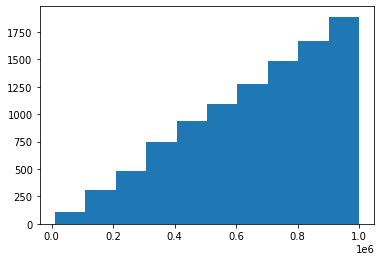

In [36]:
plt.hist(idxs_pick.cpu().numpy())

In [6]:
import joblib

In [7]:
joblib.dump(vsoed, folder + 'itr_0.pkl')

TypeError: cannot pickle 'module' object

In [9]:
vsoed.nkld_rw_f

<function vsOED.vsoed.VSOED.__init__.<locals>.nkld_rw_f(*args, **kws)>

In [51]:
torch.tensor(())

tensor([])

In [36]:
{'a': 1}.update({'b': 5})

In [10]:
np.random.choice(int(1e10), 10)

array([6377791278, 7037998855, 7556092991, 8217385358, 8695645867,
       1645853955, 1283211782, 8616980401, 3169416485, 1613878827])

In [ ]:
dict().update